In [24]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
import datetime as dat

# Mixture models

In [1]:
class mixture_loss_model():
    
    def __init__(self, f1, f2):
        self.body = f1
        self.tail = f2
        self.d = f1.d + f2.d + 1
        self.parm_names = np.append(np.append(f1.parm_names, f2.parm_names), 
                                    np.array(['p']))
    
    def set_logp(self, X):
        self.body.set_logp(X), self.tail.set_logp(X)
        body_d, tail_d, logp_body, logp_tail = self.body.d, self.tail.d,\
            self.body.logp,self.tail.logp
        def logp(parms):
            parms_f1, parms_f2, p = parms[:body_d], \
                parms[body_d: (body_d + tail_d)], p = parms[-1] 
            if γ > 0 and p > 0 and p < 1:
                X1 = X[X < γ]
                X2 = X[X >= γ]
                return(len(X1) * np.log(p) + 
                       logp_body(X1, parms_f1, γ) + 
                       len(X2) * np.log(1-p) + logp_tail(X2, parms_f2, γ))
            else:
                return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)

        
    def sample(self, parms, n):
        parms_f1, parms_f2, γ = parms[:self.body.d],\
            parms[self.body.d: (self.body.d + self.tail.d)], \
                parms[(self.body.d + self.tail.d)]
        model_type, cdf1, cdf2, pdf1, pdf2 = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf
        if model_type == "disjoint":
            p = parms[-1]
        elif model_type == "simple":
            p = cdf1(parms_f1, γ)
        elif model_type == "continuous":
            p =  pdf2(parms_f2, γ) / (1 - cdf2(parms_f2, γ)) / ( pdf2(parms_f2, γ) / (1 - cdf2(parms_f2, γ)) + pdf1(parms_f1, γ) / cdf1(parms_f1, γ)) 
        
        ber_rvs = np.random.binomial(1, p, size=n)
        unif_rvs = np.random.uniform(size = n)
        body_rvs = self.body.ppf(parms_f1, 
                                 self.body.cdf(parms_f1, γ) * unif_rvs )
        tail_rvs = self.tail.ppf(parms_f2,
                                 1 - (1 - self.tail.cdf(parms_f2, γ)) * unif_rvs)
        return(ber_rvs * body_rvs + (1 - ber_rvs) * tail_rvs)
    
    def set_logd(self, parms):
        parms_f1, parms_f2, γ = parms[:,:self.body.d],\
            parms[:,self.body.d: (self.body.d + self.tail.d)],\
                parms[:,(self.body.d + self.tail.d)] 
        model_type, cdf1, cdf2, pdf1, pdf2 = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf
        if model_type == "disjoint":
            p = parms[:,-1]
        elif model_type == "simple":
            p = np.array([cdf1(parm_f1, γ[j] ) for j, parm_f1 in enumerate(parms_f1)])
        elif model_type == "continuous":
            p = np.array([pdf2(parm_f2, gam) / (1 - cdf2(parm_f2, gam)) / ( pdf2(parm_f2, gam) / (1 - cdf2(parm_f2, gam)) + pdf1(parm_f1, gam) / cdf1(parm_f1, gam)) for parm_f1, parm_f2, gam in zip(parms_f1, parms_f2, γ) ])
        def logd(x):
            res = np.zeros(len(γ))
            s = np.logical_and(p > 0, p < 1)
            s1 = np.logical_and(s, x < γ)
            s2 = np.logical_and(s, x >= γ)
            res1 = self.body.logd_body(x, parms_f1[s1], γ[s1])    
            res2 = self.tail.logd_tail(x, parms_f2[s2], γ[s2])
            res[np.where(s1)] = res1
            res[np.where(s2)] = res2
            res[np.where(np.invert(s))] = - np.inf
            return(res)
        self.logd = logd

In [37]:
# danish = pd.read_csv("Data/danish.csv").x
ausautoBI8999 = pd.read_csv("Data/ausautoBI8999.csv")
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([dat.datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)
aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
months = np.unique(aus['FinMth'])
selec = aus['FinMth'].values == months[0]   
X = aus['scaled_aggclaims'].iloc[selec].values

149

In [31]:
f1, f2 =  bsm.loss_model("Gamma", ["α1", "σ1"]), bsm.loss_model("Lomax", ["α2", "σ2"])
f = spliced_loss_model(f1 , f2, "disjoint") 
α1_prior, σ1_prior = bsm.prior_model('gamma','α1', 1, 1), bsm.prior_model('gamma','σ1', 1, 1)
α2_prior, σ2_prior = bsm.prior_model('gamma','α2',1, 1), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([α1_prior, σ1_prior,α2_prior, σ2_prior, γ_prior, p_prior])

In [42]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 5000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma-beta prior distribution
Generation: 1 ;temperature: 0.005812644958496094 ;ESS: 2499 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.01667100210534045 ;ESS: 2500 ;steps:3 ;particle moved: 100.0%
Generation: 3 ;temperature: 0.03221966622429134 ;ESS: 2500 ;steps:3 ;particle moved: 99.96000000000001%
Generation: 4 ;temperature: 0.05695072351404733 ;ESS: 2500 ;steps:3 ;particle moved: 100.0%
Generation: 5 ;temperature: 0.09665665648590893 ;ESS: 2500 ;steps:3 ;particle moved: 99.96000000000001%
Generation: 6 ;temperature: 0.15497351980220547 ;ESS: 2500 ;steps:3 ;particle moved: 99.82%
Generation: 7 ;temperature: 0.25060441988528004 ;ESS: 2499 ;steps:3 ;particle moved: 99.76%
Generation: 8 ;temperature: 0.45469829081536434 ;ESS: 2500 ;steps:3 ;particle moved: 99.78%
Generation: 9 ;temperature: 0.8707875940437853 ;ESS: 2500 ;steps:3 ;particle moved: 99.52%
Generation: 10 ;temperature: 1.0 ;ESS: 4759 ;steps:3 ;particle mo

α1    0.882137
σ1    0.600840
α2    2.126154
σ2    0.362803
γ     0.085663
p     0.848144
dtype: float64
533.6648743225236 -65.82724135078286 -1157.1674251014392


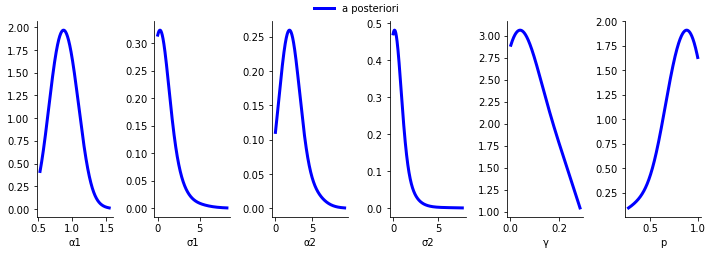

In [43]:
print(trace.mean())
print(log_marg, DIC, WAIC)
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace[f.parm_names[k]]), max(trace[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace[f.parm_names[k]], bw_method = 1)
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")
    # axs[k].plot(trace[f.parm_names[k]], lw=3, label = "a posteriori", color = "blue")
    # axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    # axs[k].set_yticks([])
    # axs[k].set_xticks(np.round(
    #     trace[f.parm_names[k]].quantile([0.0005, 0.9995]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

α1    1.971499
σ1    2.043526
α2    0.567958
σ2    0.910354
γ     7.031119
dtype: float64 [2.  2.  0.5 1.  7.  0.9]
-2768.5505653034625 5494.708721444044 4715.341319573486


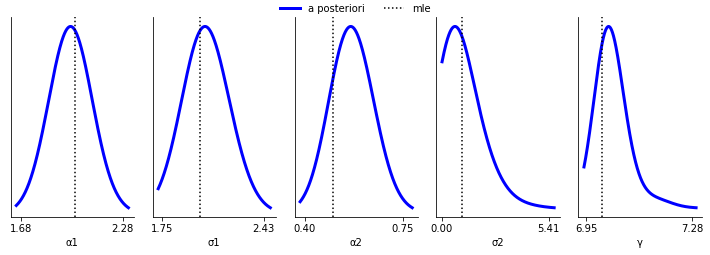

In [24]:
print(trace.mean())
print(log_marg, DIC, WAIC)
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace[f.parm_names[k]]), max(trace[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace[f.parm_names[k]], bw_method = 1)
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xticks(np.round(
        trace[f.parm_names[k]].quantile([0.0005, 0.9995]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

Wall time: 893 ms


-inf

In [94]:
parms = parms_true
body_d, tail_d, logp_body, logp_tail = f.body.d, f.tail.d,\
            f.body.logp_body,f.tail.logp_tail
        
model_type, cdf1, cdf2, pdf1, pdf2 = f.model_type, f.body.cdf, f.tail.cdf, f.body.pdf, f.tail.pdf
# def logp(parms):
parms_f1, parms_f2, γ = parms[:body_d], \
        parms[body_d: (body_d + tail_d)], \
            parms[(body_d + tail_d)] 

if model_type == "disjoint":
    p = parms[-1]
elif model_type == "simple":
    p = cdf1(parms_f1, γ)
elif model_type == "continuous":
    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ)
    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ)
    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
        p =  s2 / (1 - S2) / ( s2 / (1 - S2) + s1 / S1)
        
    else:
        p = 0
if γ > 0 and p > 0 and p < 1:
    X1 = X[X < γ]
    X2 = X[X >= γ]
    if len(X1) == 0:
        print(len(X2) * np.log(1-p) + logp_tail(X2, parms_f2, γ))
    elif len(X2) == 0:
        print(len(X1) * np.log(p) + 
               logp_body(X1, parms_f1, γ))
    else:
        print(len(X1) * np.log(p) + 
               logp_body(X1, parms_f1, γ) + 
               len(X2) * np.log(1-p) + logp_tail(X2, parms_f2, γ))
else:
    print(-np.inf)


-3074.8004914898547


In [36]:
μ1_prior, σ1_prior = bsm.prior_model('normal','μ1', 0, 2), bsm.prior_model('gamma','σ1', 1, 1)
μ2_prior, σ2_prior = bsm.prior_model('normal','μ2', 0, 2), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1,1), bsm.prior_model('beta', 'p', 0.5, 0.5)
prior_spliced_model = bsm.independent_priors([μ1_prior, σ1_prior, μ2_prior, σ2_prior, γ_prior])
particles = prior_spliced_model.sample(5000).values
for particle in particles:
    f.logp(particle) 
    

In [37]:
f.set_logd(particles)
%time logds = [f.logd(x) for x in X]

Wall time: 494 ms


Sample generation 0 from the normal-gamma-normal-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.00018405914306640625 ;ESS: 1000 ;steps:3 ;particle moved: 99.9%
Generation: 2 ;temperature: 0.0014246752448343614 ;ESS: 1000 ;steps:3 ;particle moved: 99.7%
Generation: 3 ;temperature: 0.0037623719266315896 ;ESS: 1000 ;steps:3 ;particle moved: 99.6%
Generation: 4 ;temperature: 0.00856460792746994 ;ESS: 1000 ;steps:3 ;particle moved: 98.65%
Generation: 5 ;temperature: 0.02128247206227151 ;ESS: 1000 ;steps:4 ;particle moved: 98.9%
Generation: 6 ;temperature: 0.05601272217569192 ;ESS: 1000 ;steps:4 ;particle moved: 98.2%
Generation: 7 ;temperature: 0.1621808467994919 ;ESS: 1000 ;steps:4 ;particle moved: 98.35000000000001%
Generation: 8 ;temperature: 0.5259191007854543 ;ESS: 999 ;steps:4 ;particle moved: 97.75%
Generation: 9 ;temperature: 1.0 ;ESS: 1363 ;steps:4 ;particle moved: 96.35000000000001%
Wall time: 14.8 s


μ1   -0.885555
σ1    0.449961
μ2   -0.564180
σ2    1.064956
γ     1.788251
dtype: float64 [-1.          0.33333333  1.          1.          4.          0.8       ]
692.8962637839393 -681.3330578150642 -1434.3311303156265


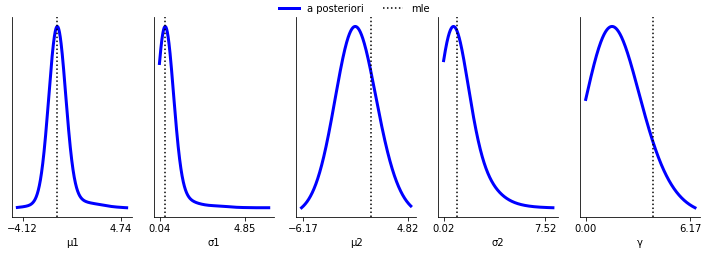

In [69]:
print(trace.mean(), parms_true)
print(log_marg, DIC, WAIC)
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace[f.parm_names[k]]), max(trace[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace[f.parm_names[k]], bw_method = 1)
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xticks(np.round(
        trace[f.parm_names[k]].quantile([0.0005, 0.9995]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()